In [1]:
# -*- coding: utf-8 -*-

## "Detection of Accounting Anomalies in the Latent Space using Adversarial Autoencoder Neural Networks"


The content of this lab notebook was jointly developed by Marco Schreyer and Timur Sattarov as part of the 2nd KDD'19 Workshop on "Anomaly Detection in Finance". Further details on the workshop can be found via the workshop <a href="https://sites.google.com/view/kdd-adf-2019">homepage</a>.

Please don't hesitate to contact us in case of any questions via <a href="mailto:marco.schreyer@unisg.ch">marco.schreyer@unisg.ch</a> and <a href="mailto:timur.sattarov@gmail.com">timur.sattarov@gmail.com</a>.

### 1.1 Python Libraries Import

In [2]:
# importing python utility libraries
import os, sys, random, io, urllib
from datetime import datetime

# importing pytorch libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

# importing data science libraries
import pandas as pd
import random as rd
import numpy as np

# importing python plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
from IPython.display import Image, display

### 1.2 CUDNN and GPU Verification

To determine if CDNN is available on the server let's execute the cell below to display information about the available CUDNN version:

In [3]:
# print CUDNN backend version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The CUDNN backend version: {}'.format(now, torch.backends.cudnn.version()))

[LOG 20200504-21:57:04] The CUDNN backend version: None


Also, let's display information about the potential GPUs running on the server:

In [4]:
!nvidia-smi

/bin/sh: nvidia-smi: command not found


If CUDNN and GPU's are available let's still specify if we want to use both:

In [5]:
USE_CUDA = True

### 1.3 Python and PyTorch Verification

Let's execute the cell below to display information about the Python and PyTorch version running on the server:

In [6]:
# print current Python version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The Python version: {}'.format(now, sys.version))

[LOG 20200504-21:57:04] The Python version: 3.7.6 (default, Dec 30 2019, 19:38:26) 
[Clang 11.0.0 (clang-1100.0.33.16)]


In [7]:
# print current PyTorch version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The PyTorch version: {}'.format(now, torch.__version__))

[LOG 20200504-21:57:04] The PyTorch version: 1.4.0


### 1.4 Random Seed Initialization

Finally, let' set the seeds of random elements in the code e.g. the initialization of the network parameters to guarantee deterministic computation and results:

In [8]:
# init deterministic seed
seed_value = 1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    torch.cuda.manual_seed(seed_value) # set pytorch seed GPU

### 1.5 Folder Structure Initialization

Create notebook structure to store the data as well as the trained models:

In [9]:
if not os.path.exists('./data'): os.makedirs('./data')  # create data directory
if not os.path.exists('./models_1024'): os.makedirs('./models_1024')  # create trained models directory

## 2. Financial Fraud Detection Dataset

In this section, we will conduct a descriptive analysis of the financial dataset. Furthermore, we will apply some necessary pre-processing steps to train a deep neural network. The dataset is based on a derivation of the **"Synthetic Financial Dataset For Fraud Detection"** by Lopez-Rojas [6] available via the Kaggle predictive modelling and analytics competitions platform that can be obtained using the following link: https://www.kaggle.com/ntnu-testimon/paysim1.

In [10]:
# load the synthetic ERP dataset
#ori_dataset = pd.read_csv('./data/fraud_dataset_v2.csv')

# load the synthetic ERP dataset
url = 'https://raw.githubusercontent.com/GitiHubi/deepAI/master/data/fraud_dataset_v2.csv'
ori_dataset = pd.read_csv(url)

Let's now inspect the dataset dimensions in terms of the number of journal entries and number of attributes contained:

In [11]:
# inspect the dataset dimensions
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] Transactional dataset of {} rows and {} columns loaded'.format(now, ori_dataset.shape[0], ori_dataset.shape[1]))

[LOG 20200504-21:57:07] Transactional dataset of 533009 rows and 10 columns loaded


### 2.1 Initial Data and Attribute Assessment

We augmented the dataset and renamed the attributes to appear more similar to a real-world dataset that one usually observes in SAP-ERP systems as part of SAP's Finance and Cost controlling (FICO) module. 

The dataset contains a subset of in total 7 categorical and 2 numerical attributes available in the FICO BKPF (containing the posted journal entry headers) and BSEG (containing the posted journal entry segments) tables. Please, find below a list of the individual attributes as well as a brief description of their respective semantics:

>- `BELNR`: the accounting document number,
>- `BUKRS`: the company code,
>- `BSCHL`: the posting key,
>- `HKONT`: the posted general ledger account,
>- `PRCTR`: the posted profit center,
>- `WAERS`: the currency key,
>- `KTOSL`: the general ledger account key,
>- `DMBTR`: the amount in local currency,
>- `WRBTR`: the amount in document currency.

Let's also have a closer look into the top 10 rows of the dataset:

In [12]:
# inspect top rows of the ERP dataset
ori_dataset.head(10) 

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular
5,327203,C1,C15,C6,C68,A1,B2,357627.56,704520.00,regular
6,292545,C4,C47,C2,C28,A2,B3,955576.84,128328.00,regular
7,335839,C1,C19,C1,C17,A1,B1,41769.26,0.00,regular
8,369064,C4,C40,C9,C97,A2,B1,44309.79,0.00,regular
9,138724,C6,C69,C1,C12,A2,B1,466720.45,43843.00,regular


You may also have noticed the attribute `label` in the data. We will use this field throughout the lab to evaluate the quality of our trained models. The field describes the true nature of each individual transaction of either being a **regular** transaction (denoted by `regular`) or an **anomaly** (denoted by `global` and `local`). Let's have closer look into the distribution of the regular vs. anomalous transactions in the dataset:

In [13]:
# number of anomalies vs. regular transactions
ori_dataset.label.value_counts()

regular    532909
global         70
local          30
Name: label, dtype: int64

Ok, the statistic reveals that, similar to real world scenarios, we are facing a highly "unbalanced" dataset. Overall, the dataset contains only a small fraction of **100 (0.018%)** anomalous transactions. While the 100 anomalous entries encompass **70 (0.013%)** "global" anomalies and **30 (0.005%)** "local" anomalies as introduced in section 1.2.

In [14]:
# remove the "ground-truth" label information for the following steps of the lab
label = ori_dataset.pop('label')

### 2.2 Pre-Processing of Categorical Transaction Attributes

From the initial data assessment above we can observe that the majority of attributes recorded in AIS- and ERP-systems contain categorical (discrete) attribute values, e.g. the posting date, the general-ledger account, the posting type, the currency. Let's visually inspect the distribution of two of the dataset attributes provided, namely (1) the posting key (technically denoted by `BSCHL`) as well as (2) the general ledger account (technically denoted by `HKONT`):

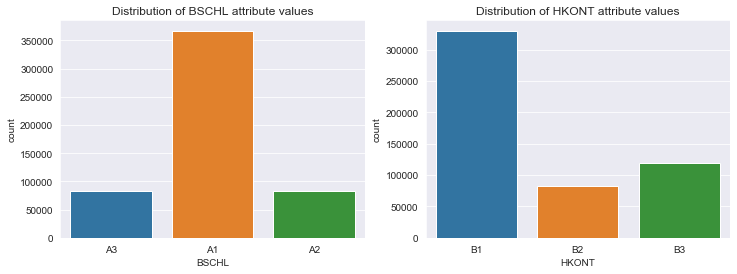

In [15]:
# prepare to plot posting key and general ledger account side by side
fig, ax = plt.subplots(1,2)
fig.set_figwidth(12)

# plot the distribution of the posting key attribute
g = sns.countplot(x=ori_dataset.loc[label=='regular', 'BSCHL'], ax=ax[0])
g.set_xticklabels(g.get_xticklabels(), rotation=0)
g.set_title('Distribution of BSCHL attribute values')

# plot the distribution of the general ledger account attribute
g = sns.countplot(x=ori_dataset.loc[label=='regular', 'HKONT'], ax=ax[1])
g.set_xticklabels(g.get_xticklabels(), rotation=0)
g.set_title('Distribution of HKONT attribute values');

Unfortunately, neural networks are in general not designed to be trained directly on categorical data and require the attributes to be trained on to be numeric. One simple way to meet this requirement is by applying a technique referred to as "one-hot" encoding. Using this encoding technique, we will derive a numerical representation of each of the categorical attribute values. One-hot encoding creates new binary columns for each categorical attribute value present in the original data.

Let's work through a brief example: The categorical attribute “Receiver” below contains the names "John", "Timur" and "Marco". We "one-hot" encode the names by creating a separate binary column for each possible name value observable in the "Receiver" column. Now, we encode for each transaction that contains the value "John" in the "Receiver" column this observation with 1.0 in the newly created "John" column and 0.0 in all other created name columns.

<img align="middle" style="max-width: 600px; height: auto" src="https://github.com/GitiHubi/deepAD/blob/master/images/encoding.png?raw=1">

Using this technique will "one-hot" encode the 6 categorical attributes in the original transactional dataset to obtain a binary ("one-hot" encoded) representation of each attribute. This can be achieved using the get_dummies() function available in the Pandas data science library:

In [16]:
# select categorical attributes to be "one-hot" encoded
categorical_attr_names = ['KTOSL', 'PRCTR', 'BSCHL', 'HKONT', 'BUKRS', 'WAERS']

# encode categorical attributes into a binary one-hot encoded representation 
ori_dataset_categ_transformed = pd.get_dummies(ori_dataset[categorical_attr_names])

Finally, let's inspect the encoding of 10 sample transactions to see if we have been successfull:

In [17]:
# inspect encoded sample transactions
ori_dataset_categ_transformed.head(10)

,KTOSL_A19,KTOSL_B06,KTOSL_B12,KTOSL_B83,KTOSL_C1,KTOSL_C2,KTOSL_C3,KTOSL_C39,KTOSL_C4,KTOSL_C5,...,WAERS_U72,WAERS_U94,WAERS_V89,WAERS_W25,WAERS_W59,WAERS_X26,WAERS_Y59,WAERS_Z06,WAERS_Z37,WAERS_Z54
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.2 Pre-Processing of Numerical Transaction Attributes

Let's now inspect the distributions of the two numerical attributes contained in the transactional dataset namely, the (1) local currency amount DMBTR and the (2) document currency amount WRBTR:

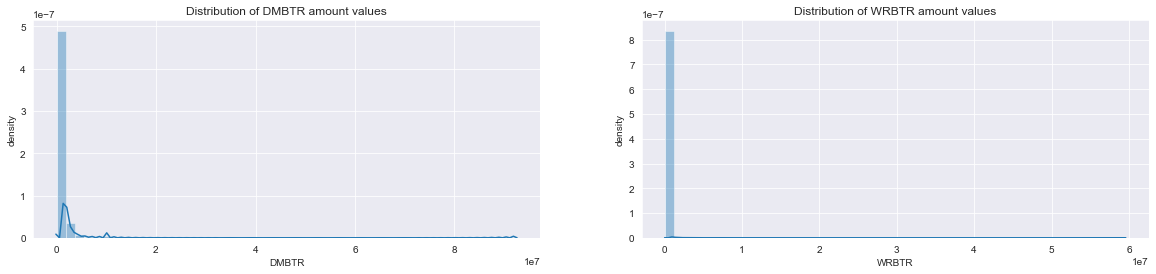

In [18]:
# init the plots
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot distribution of the local amount attribute
g = sns.distplot(ori_dataset['DMBTR'].tolist(), ax=ax[0])
g.set_title('Distribution of DMBTR amount values')

# set axis-labels 
ax[0].set_xlabel('DMBTR')
ax[0].set_ylabel('density')

# plot distribution of the document amount attribute
g = sns.distplot(ori_dataset['WRBTR'].tolist(), ax=ax[1])
g.set_title('Distribution of WRBTR amount values')

# set axis-labels
ax[1].set_xlabel('WRBTR')
ax[1].set_ylabel('density');

As expected, it can be observed, that for both attributes the distributions of amount values are skewed and encompass a heavy tailed distribution. In order to faster approach a potential global minimum it is good practice to scale and normalize numerical input values prior to network training. Therefore, we first log-scale both variables and second min-max normalize the scaled amounts to the interval [0, 1].

In [19]:
# select "DMBTR" vs. "WRBTR" attribute
numeric_attr_names = ['DMBTR', 'WRBTR']

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = ori_dataset[numeric_attr_names] + 1e-4
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
ori_dataset_numeric_attr = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

Let's now visualize the log-scaled and min-max normalized distributions of both attributes:

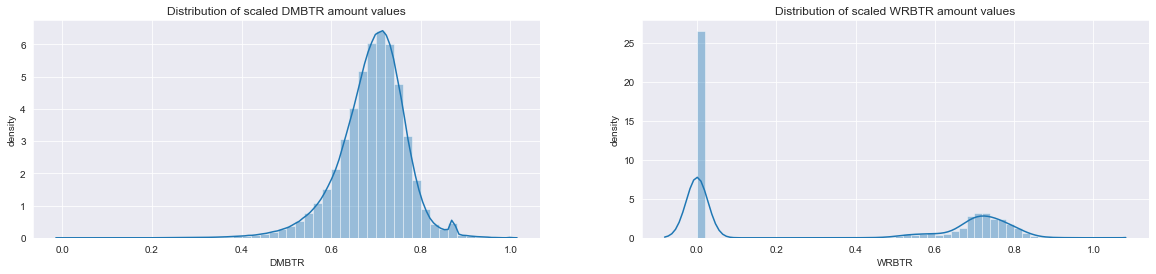

In [20]:
# init the plots
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot distribution of the local amount attribute
g = sns.distplot(ori_dataset_numeric_attr['DMBTR'].tolist(), ax=ax[0])
g.set_title('Distribution of scaled DMBTR amount values')

# set axis-labels 
ax[0].set_xlabel('DMBTR')
ax[0].set_ylabel('density')

# plot distribution of the local amount attribute
g = sns.distplot(ori_dataset_numeric_attr['WRBTR'].tolist(), ax=ax[1])
g.set_title('Distribution of scaled WRBTR amount values')

# set axis-labels
ax[1].set_xlabel('WRBTR')
ax[1].set_ylabel('density');

Ok, let's now visually investigate the scaled distributions of both attributes in terms of the distinct anomaly classes contained in the population of journal entries:

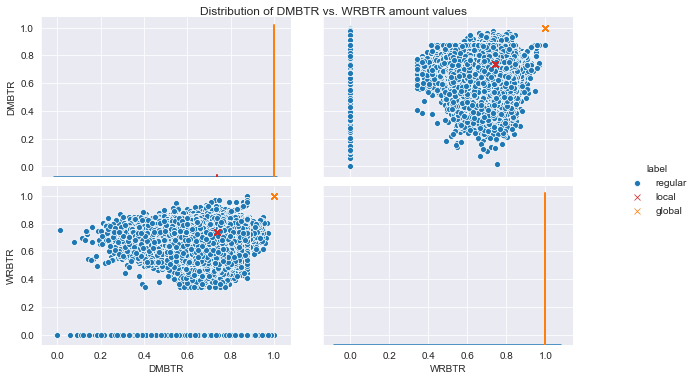

In [21]:
# append 'label' attribute 
numeric_attr_vis = ori_dataset_numeric_attr.copy()
numeric_attr_vis['label'] = label

# plot the log-scaled and min-max normalized numeric attributes
g = sns.pairplot(data=numeric_attr_vis, vars=numeric_attr_names, hue='label', palette={'regular': 'C0', 'local': 'C3', 'global': 'C1'}, markers=['o', 'x', 'x'])

# set figure title
g.fig.suptitle('Distribution of DMBTR vs. WRBTR amount values', y=1.02)

# set figure size
g.fig.set_size_inches(10, 5)

Ok, as anticipated the numeric attribute values of the "global" anomalies (orange) fall outside the range of the regular amount distributions due to their unusual high amount values. In contrast, the numeric attribute values of the "local" anomalies (red) are much more commingled within the regular transaction amounts.
As DMBTR attribute contains a number of extreme values we might want to visulalize its distribution by omitting those set of extreme values.

### 2.3 Merge Categorical and Numerical Transaction Attributes

Finally, we merge both pre-processed numerical and categorical attributes into a single dataset that we will use for training our deep autoencoder neural network (explained an implemented in the following section 4.):

In [22]:
# merge categorical and numeric subsets
ori_subset_transformed = pd.concat([ori_dataset_categ_transformed, ori_dataset_numeric_attr], axis = 1)

Now, let's again have a look at the dimensionality of the dataset after we applied the distinct pre-processing steps to the attributes:

In [23]:
# inspect final dimensions of pre-processed transactional data
ori_subset_transformed.shape

(533009, 618)

Ok, upon completion of all the pre-processing steps (incl. the exercises) we should end up with an encoded dataset consisting of a total number of 533,009 records (rows) and **618 encoded attributes** (columns). Let's keep the number number of columns in mind since it will define the dimensionality of the input- and output-layer of our deep autoencoder network which we will now implement in the following section.

## 3. Adversarial Autoencoder Neural Network

The Adversarial Autoencoder Neural Network (AAE) architecture, as illustrated in the figure below, extends the concept
of Autoencoder Neural Networks (AE) by imposing an arbitrary prior on the AEs latent space using a GAN training setup. This is achieved by training the AAE jointly in two phases (1) a reconstruction phase as well as (2) an adversarial regularization phase.

In the reconstruction phase, the AAEs encoder network $q_{\theta}(z|x)$ is trained to learn an aggregated posterior distribution $q(z)$ of the journal entries $X$ over the latent code vector $Z$. Thereby, the learned posterior distribution corresponds to a compressed representation of the journal entry characteristics. Similarly to AENs, the decoder
network $p_{\theta}(\hat{x}|z)$ of the AAE utilizes the learned latent code vector representations $Z$ to reconstruct the journal entries $\hat{X}$ as faithfully as possible to minimize the AAEs reconstruction error.

In the regularization phase, an adversarial training setup is applied were the encoder network $q_{\theta}(z|x)$ of the AAE functions as the generator network. In addition, a discriminator network $d_{\theta}(z)$ is attached on top of the learned latent code vector $Z$. Similarly to GANs, the discriminator network of the AAE is trained to distinguish samples of an imposed prior distribution $p(z)$ onto $Z$ from the learned aggregated posterior distribution $q(z)$. In contrast, the encoder network is trained to learn a posterior distribution $p(z) ≈ q(z)$ that fools the discriminator network into thinking that the samples drawn from $q(z)$ originate from the imposed prior distribution $p(z)$.

<img align="middle" style="max-width: 830px; height: auto" src="https://github.com/GitiHubi/deepAD/blob/master/images/autoencoder_2.png?raw=1">

### 3.1 AAE Implementation - Encoder / Generator Network $q_{\theta}(z|x)$

Now, let's start implementing an AAE by first implementing the encoder-generator network $q_{\theta}(z|x)$ using PyTorch. For the encoder-generator, we aim to implement a network consisting of **five fully-connected layers**. Furthermore, the encoder-generator is specified by the following number of neurons per layer: "618-256-64-16-4-2". Meaning the first layer consists of 618 neurons (specified by the dimensionality of our input data), the second layer of 256 neurons and the subsequent layers of 64, 16, 4 and 2 neurons respectively.

Some elements of the encoder network code below should be given particular attention:

>- `self.encoder_Lx`: defines the linear transformation of the layer applied to the incoming input: $Wx + b$.
>- `nn.init.xavier_uniform`: inits the layer weights using a uniform distribution according to [9].
>- `nn.init.constant`: inits the layer bias with a constant value of 0.0. 
>- `self.encoder_Rx`: defines the non-linear transformation of the layer: $\sigma(\cdot)$.

We use **"Leaky ReLUs"** as introduced by Xu et al. in [7] to avoid "dying" non-linearities and to speed up training convergence. Leaky ReLUs allow a small gradient even when a particular neuron is not active.

In [24]:
# define encoder class
class Encoder(nn.Module):

    # define class constructor
    def __init__(self, input_size, hidden_size):

        # call super class constructor
        super(Encoder, self).__init__()

        # specify first layer - in 618, out 256
        self.map_L1 = nn.Linear(input_size, hidden_size[0], bias=True) # init linearity
        nn.init.xavier_uniform_(self.map_L1.weight) # init weights according to [9]
        nn.init.constant_(self.map_L1.bias, 0.0) # constant initialization of the bias
        self.map_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 256, out 64
        self.map_L2 = nn.Linear(hidden_size[0], hidden_size[1], bias=True)
        nn.init.xavier_uniform_(self.map_L2.weight)
        nn.init.constant_(self.map_L2.bias, 0.0)
        self.map_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 64, out 16
        self.map_L3 = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map_L3.weight)
        nn.init.constant_(self.map_L3.bias, 0.0)
        self.map_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify fourth layer - in 16, out 4
        self.map_L4 = nn.Linear(hidden_size[2], hidden_size[3], bias=True)
        nn.init.xavier_uniform_(self.map_L4.weight)
        nn.init.constant_(self.map_L4.bias, 0.0)
        self.map_R4 = torch.nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify fifth layer - in 4, out 2
        self.map_L5 = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map_L5.weight)
        nn.init.constant_(self.map_L5.bias, 0.0)
        self.map_R5 = torch.nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.map_R1(self.map_L1(x))
        x = self.map_R2(self.map_L2(x))
        x = self.map_R3(self.map_L3(x))
        x = self.map_R4(self.map_L4(x))
        x = self.map_R5(self.map_L5(x))

        # return result
        return x

Now, we are ready to instantiate the encoder-generator model to be trained on the CPU or to be trained on any of the available GPUs (if CUDNN is available and `USE_CUDA` is set to `True`) by execution of the following cell:

In [25]:
# init training network classes / architectures
encoder_train = Encoder(input_size=ori_subset_transformed.shape[1], hidden_size=[256, 64, 16, 4, 2])

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    encoder_train = encoder_train.cuda()

Once the model is initialized we can visualize the model structure and review the implemented network architecture by execution of the following cell:

In [26]:
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] encoder-generator architecture:\n\n{}\n'.format(now, encoder_train))

[LOG 20200504-21:57:24] encoder-generator architecture:

Encoder(
  (map_L1): Linear(in_features=618, out_features=256, bias=True)
  (map_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L2): Linear(in_features=256, out_features=64, bias=True)
  (map_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L3): Linear(in_features=64, out_features=16, bias=True)
  (map_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L4): Linear(in_features=16, out_features=4, bias=True)
  (map_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L5): Linear(in_features=4, out_features=2, bias=True)
  (map_R5): LeakyReLU(negative_slope=0.4, inplace=True)
)



Looks, great? Excellent!

### 3.2 AAE Implementation - Decoder Network $p_{\theta}(x|z)$

Let's continue the AAE by implementing the corresponding decoder network. The decoder also consists of five fully-connected layers. Furthermore, the decoder network is intended to **symmetrically mirror** the encoder networks architecture by a layer wise inversion "2-4-16-64-256" of the encoder network layers.

In [27]:
# define decoder class
class Decoder(nn.Module):

    # define class constructor
    def __init__(self, output_size, hidden_size):

        # call super class constructor
        super(Decoder, self).__init__()

        # specify first layer - in 2, out 4
        self.map_L1 = nn.Linear(hidden_size[0], hidden_size[1], bias=True) # init linearity
        nn.init.xavier_uniform_(self.map_L1.weight) # init weights according to [9]
        nn.init.constant_(self.map_L1.bias, 0.0) # constant initialization of the bias
        self.map_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 4, out 16
        self.map_L2 = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map_L2.weight)
        nn.init.constant_(self.map_L2.bias, 0.0)
        self.map_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 16, out 64
        self.map_L3 = nn.Linear(hidden_size[2], hidden_size[3], bias=True)
        nn.init.xavier_uniform_(self.map_L3.weight)
        nn.init.constant_(self.map_L3.bias, 0.0)
        self.map_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify fourth layer - in 64, out 256
        self.map_L4 = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map_L4.weight)
        nn.init.constant_(self.map_L4.bias, 0.0)
        self.map_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify fifth layer - in 256, out 618
        self.map_L5 = nn.Linear(hidden_size[4], output_size, bias=True)
        nn.init.xavier_uniform_(self.map_L5.weight)
        nn.init.constant_(self.map_L5.bias, 0.0)
        self.map_S5 = torch.nn.Sigmoid()

    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.map_R1(self.map_L1(x))
        x = self.map_R2(self.map_L2(x))
        x = self.map_R3(self.map_L3(x))
        x = self.map_R4(self.map_L4(x))
        x = self.map_S5(self.map_L5(x))

        # return result
        return x

Let's also instantiate the decoder model for CPU or GPU training and convince ourselves that it was successfully initialized by printing and reviewing its architecture by execution of the following cell:

In [28]:
# init training network classes / architectures
decoder_train = Decoder(output_size=ori_subset_transformed.shape[1], hidden_size=[2, 4, 16, 64, 256])

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    decoder_train = decoder_train.cuda()
    
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] decoder architecture:\n\n{}\n'.format(now, decoder_train))

[LOG 20200504-21:57:24] decoder architecture:

Decoder(
  (map_L1): Linear(in_features=2, out_features=4, bias=True)
  (map_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L2): Linear(in_features=4, out_features=16, bias=True)
  (map_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L3): Linear(in_features=16, out_features=64, bias=True)
  (map_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L4): Linear(in_features=64, out_features=256, bias=True)
  (map_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L5): Linear(in_features=256, out_features=618, bias=True)
  (map_S5): Sigmoid()
)



### 3.3 AAE Implementation - Discriminator Network $d_{\theta}(z)$

Let's, now as a final step, complete the AAE implementation by implementing the discriminator network $d_{\theta}(z)$. The discriminator also consists of five fully-connected layers. Furthermore, the discriminator is specified by the following number of neurons per layer: "256-16-4-2".

In [29]:
# define discriminator class
class Discriminator(nn.Module):

    # define class constructor
    def __init__(self, input_size, hidden_size, output_size):

        # call super class constructor
        super(Discriminator, self).__init__()

        # specify first layer - in 2, out 256
        self.map_L1 = nn.Linear(input_size, hidden_size[0], bias=True) # init linearity
        nn.init.xavier_uniform_(self.map_L1.weight) # init weights according to [9]
        nn.init.constant_(self.map_L1.bias, 0.0) # constant initialization of the bias
        self.map_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 256, out 16
        self.map_L2 = nn.Linear(hidden_size[0], hidden_size[1], bias=True)
        nn.init.xavier_uniform_(self.map_L2.weight)
        nn.init.constant_(self.map_L2.bias, 0.0)
        self.map_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 16, out 4
        self.map_L3 = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map_L3.weight)
        nn.init.constant_(self.map_L3.bias, 0.0)
        self.map_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify fourth layer - in 4, out 2
        self.map_L4 = nn.Linear(hidden_size[2], output_size, bias=True)
        nn.init.xavier_uniform_(self.map_L4.weight)
        nn.init.constant_(self.map_L4.bias, 0.0)
        self.map_S4 = torch.nn.Sigmoid()

    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.map_R1(self.map_L1(x))
        x = self.map_R2(self.map_L2(x))
        x = self.map_R3(self.map_L3(x))
        x = self.map_S4(self.map_L4(x))

        # return result
        return x

Let's also instantiate the discriminator model for CPU or GPU training and convince ourselves that it was successfully initialized by printing and reviewing its architecture by execution of the following cell:

In [30]:
# init training network classes / architectures
discriminator_train = Discriminator(input_size=2, hidden_size=[256, 16, 4, 2], output_size=1)

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    discriminator_train = discriminator_train.cuda()
    
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] discriminator architecture:\n\n{}\n'.format(now, discriminator_train))

[LOG 20200504-21:57:24] discriminator architecture:

Discriminator(
  (map_L1): Linear(in_features=2, out_features=256, bias=True)
  (map_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L2): Linear(in_features=256, out_features=16, bias=True)
  (map_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L3): Linear(in_features=16, out_features=4, bias=True)
  (map_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L4): Linear(in_features=4, out_features=1, bias=True)
  (map_S4): Sigmoid()
)



### 3.4 Adversarial Autoencoder Neural Network Training

Now that we have implemented the AAE we are ready to train the network. Prior to starting the training, we need to define an appropriate loss functions, learning rates and parameter optimization techniques. Remember, we aim to train the adversarial autoencoder jointly in two training phases, namely (1) a reconstruction phase as well as (2) a regularization phase. In the following we will set the training parameters of each training phase.

#### 3.4.1 Reconstruction Phase Parameter

In the reconstruction phase, the AAEs encoder network $q_{\theta}(z|x)$ is trained to learn an aggregated posterior distribution $q(z)$ of the journal entries $X$ over the latent code vector $Z$. Thereby, the learned posterior distribution corresponds to a compressed representation of the journal entry characteristics. Similarly to AENs, the decoder network $p_{\theta}(\hat{x}|z)$ of the AAE utilizes the learned latent code vector representations $Z$ to reconstruct the journal entries $\hat{X}$ as faithfully as possible to minimize the AAEs reconstruction error.

To achieve this optimization objective, we calculate (1) the **binary cross-entropy reconstruction error (BCE)** of the categorical attribute value encodings $x^{i}_{cat}$, e.g., the encoded general ledger account ids, and (2) the **mean-squared reconstruction error (MSE)** of the numerical attribute value encodings $x^{i}_{con}$, e.g., the encoded posting amount, as given by:

$\mathcal{L}_{\theta}^{REC}(x^{i};\hat{x}^{i}) = \gamma \hspace{1mm} \mathcal{L}^{CE}_{\theta}(x^{i}_{cat};\hat{x}^{i}_{cat}) + (1 - \gamma) \hspace{1mm} \mathcal{L}^{MSE}_{\theta}(x^{i}_{con};\hat{x}^{i}_{con})$

for a set of $n$-journal entries $x^{i}$, $i=1,...,n$ and their respective reconstructions $\hat{x}^{i}$ and all journal entry attributes $j=1,...,k$. Luckily, an implementation of the BCE and MSE loss is already available in PyTorch. It can be instantiated "off-the-shelf" via execution of the following PyTorch commands:

In [31]:
# define the optimization criterion / loss function
reconstruction_criterion_categorical = nn.BCELoss(reduction='mean')
reconstruction_criterion_numeric = nn.MSELoss(reduction='mean')

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    reconstruction_criterion_categorical = reconstruction_criterion_categorical.cuda()
    reconstruction_criterion_numeric = reconstruction_criterion_numeric.cuda()

We will use the Adam optimization as proposed in [11] and set the learning-rate  l=0.001. Each mini-batch step the optimizer will update the encoder- and decoder-parameters $\theta$ according to degree of reconstruction error.

In [32]:
# define encoder and decoded learning rate
learning_rate_enc = 1e-3
learning_rate_dec = 1e-3

# define encoder and decoder optimization strategy
encoder_optimizer = optim.Adam(encoder_train.parameters(), lr=learning_rate_enc)
decoder_optimizer = optim.Adam(decoder_train.parameters(), lr=learning_rate_dec)

#### 3.4.2 Regularization Phase Parameter

In the regularization phase, an adversarial training setup is applied were the encoder network $q_{\theta}(z|x)$ of the AAE functions as the generator network. In addition, a discriminator network $d_{\phi}(z)$ is attached on top of the learned latent code vector $Z$. Similarly to GANs, the discriminator network of the AAE is trained to distinguish samples of an imposed prior distribution $p(z)$ onto $Z$ from the learned aggregated posterior distribution $q(z)$. In contrast, the encoder network is trained to learn a posterior distribution $p(z) \approx q(z)$ that fools the discriminator network into thinking that the samples drawn from $q(z)$ originate from the imposed prior distribution $p(z)$.

To achieve this optimization objective, we calculate the **binary cross-entropy reconstruction error (BCE)**, as given by:

In [33]:
# init the discriminator losses
discriminator_criterion = nn.BCELoss()

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    discriminator_criterion = discriminator_criterion.cuda()

We will use the Adam optimization as proposed in [11] and set the learning-rate  l=0.00001. Each mini-batch step the optimizer will update the generator parameters $\theta$ as well as the discriminator parameters $\phi$ according to degree of discrimination error.

In [34]:
# define generator and discriminator learning rate
learning_rate_dis_z = 1e-5

# define generator and discriminator optimization strategy
discriminator_optimizer = optim.Adam(discriminator_train.parameters(), lr=learning_rate_dis_z)

Now that we have successfully implemented and defined the three AAE building blocks let's take some time to review the `encoder-generator`, `decoder` and `discriminator` model definition as well as the loss. Please, read the above code and comments carefully and don't hesitate to let us know any questions you might have.

### 3.5 Creation of the Imposed Latent Prior Distribution $p(z)$

In order to partition the journal entry representations learned by the AAE, we sample from a prior distribution $p(z)$ comprised of a mixture of $\tau$ multivariate isotropic Gaussians $\mathcal{N}(\mu,\mathcal{I})$, where $\mu \in \mathcal{R}^{2}$. In the following example we create a prior distribution $p(z)$ consisting $\tau=5$ isotropic Gaussians.

In [35]:
# define the number of gaussians
tau = 5 

# define radius of each gaussian
radius = 0.8

# define the sigma of each gaussian
sigma = 0.01

# define the dimensionality of each gaussian
dim = 2

# determine x and y coordinates of the target mixture of gaussians
x_centroid = (radius * np.sin(np.linspace(0, 2 * np.pi, tau, endpoint=False)) + 1) / 2
y_centroid = (radius * np.cos(np.linspace(0, 2 * np.pi, tau, endpoint=False)) + 1) / 2

# determine each gaussians mean (centroid) and standard deviation
mu_gauss = np.vstack([x_centroid, y_centroid]).T

# determine the number of samples to be created per gaussian
samples_per_gaussian = 100000

# iterate over the number of distinct gaussians
for i, mu in enumerate(mu_gauss):

    # case: first gaussian
    if i == 0:

        # randomly sample from gaussion distribution 
        z_continous_samples_all = np.random.normal(mu, sigma, size=(samples_per_gaussian, dim))

    # case: non-first gaussian
    else:

        # randomly sample from gaussian distribution
        z_continous_samples = np.random.normal(mu, sigma, size=(samples_per_gaussian, dim))

        # collect and stack new samples
        z_continous_samples_all = np.vstack([z_continous_samples_all, z_continous_samples])

Let's visually inspect the generated prior distribution $p(z)$:

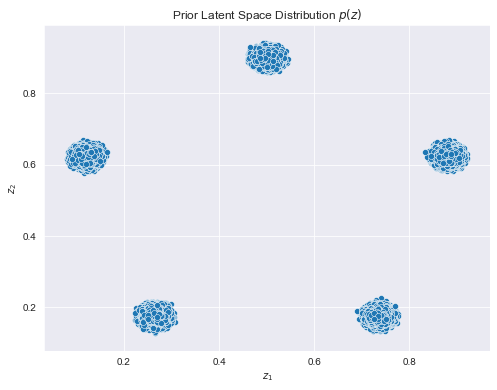

In [36]:
# init the plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# plot reconstruction error scatter plot
ax.scatter(z_continous_samples_all[:, 0], z_continous_samples_all[:, 1], c='C0', marker="o", edgecolors='w', linewidth=0.5) 
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

# add plot title
ax.set_title('Prior Latent Space Distribution $p(z)$');

Ok, great. Looks like anticipated.

In [37]:
encoder_train.load_state_dict(torch.load('./model_AAE_1024/ep_2000_encoder_model.pth', map_location=torch.device('cpu')))
decoder_train.load_state_dict(torch.load('./model_AAE_1024/ep_2000_decoder_model.pth', map_location=torch.device('cpu')))
discriminator_train.load_state_dict(torch.load('./model_AAE_1024/ep_2000_discriminator_model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [38]:
encoder_eval = encoder_train
decoder_eval = decoder_train
# convert pre-processed data to pytorch tensor
torch_dataset = torch.from_numpy(ori_subset_transformed.values).float()


In [39]:
# convert to pytorch tensor - none cuda enabled
dataloader_eval = DataLoader(torch_dataset, batch_size=131072, shuffle=False, num_workers=0)
# determine if CUDA is available at the compute node
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    # push dataloader to CUDA
    dataloader_eval = DataLoader(torch_dataset.cuda(), batch_size=mini_batch_size, shuffle=False)

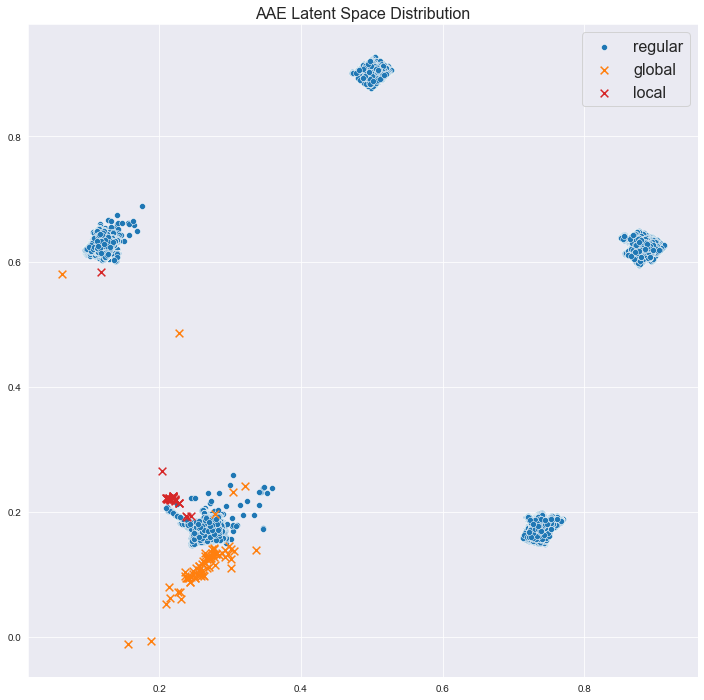

In [40]:
# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# init batch count
batch_count = 0

# iterate over epoch mini batches
for enc_transactions_batch in dataloader_eval:
    with torch.no_grad():
        # determine latent space representation of all transactions
        z_enc_transactions_batch = encoder_eval(enc_transactions_batch)
        # case: initial batch 
        if batch_count == 0:

            # collect reconstruction errors of batch
            z_enc_transactions_all = z_enc_transactions_batch

        # case: non-initial batch
        else:
            # collect reconstruction errors of batch
            z_enc_transactions_all = torch.cat((z_enc_transactions_all, z_enc_transactions_batch), 0)
            
        # increase batch count
        batch_count += 1

# convert to numpy array
z_enc_transactions_all = z_enc_transactions_all.detach().numpy()

# prepare plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

# obtain regular transactions as well as global and local anomalies
regular_data = z_enc_transactions_all[label == 'regular']
global_outliers = z_enc_transactions_all[label == 'global']
local_outliers = z_enc_transactions_all[label == 'local']

# plot reconstruction error scatter plot
ax.scatter(regular_data[:, 0], regular_data[:, 1], c='C0', marker="o", label='regular', edgecolors='w', linewidth=0.5) # plot regular transactions
ax.scatter(global_outliers[:, 0], global_outliers[:, 1], c='C1', marker="x", label='global', edgecolors='w', s=60) # plot global outliers
ax.scatter(local_outliers[:, 0], local_outliers[:, 1], c='C3', marker="x", label='local', edgecolors='w', s=60) # plot local outliers

# add plot legend of transaction classes
plt.title("AAE Latent Space Distribution", size=16)
ax.legend(loc='best', prop={'size': 16});
plt.savefig('AAE_Latent')

In [41]:
n = z_enc_transactions_all.shape[0]

In [42]:
split_ratio = 0.65
# Training Testing Split
z_enc_transactions_test = z_enc_transactions_all[int(n*split_ratio):]
z_enc_transactions_all = z_enc_transactions_all[:int(n*split_ratio)]

# Mode Divergence, Reconstruction Error, Anomaly Score (AS)

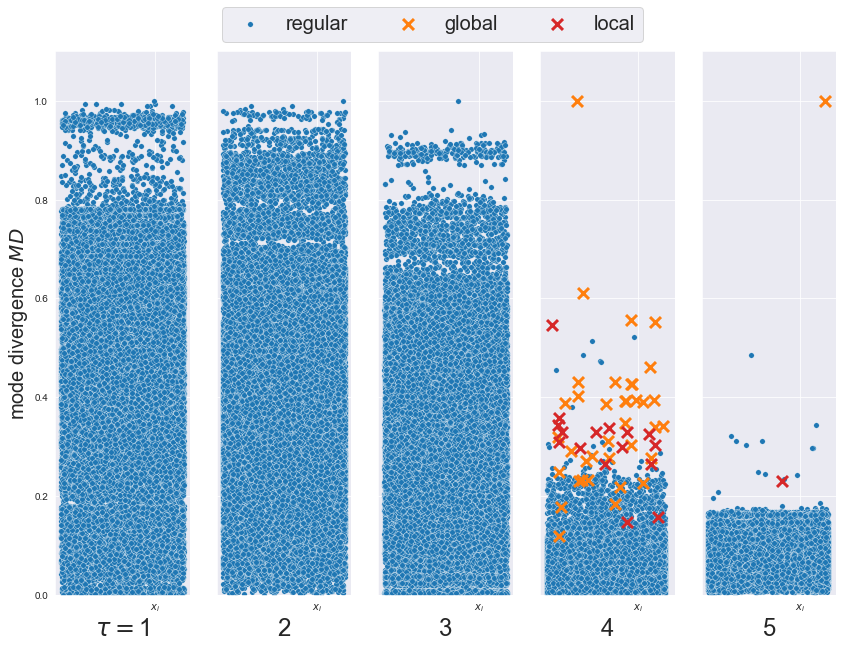

In [43]:
# define euclidean distance calculation
def compute_euclid_distance(x, y):
    
    # calculate euclidean distance 
    euclidean_distance = np.sqrt(np.sum((x - y) ** 2, axis=1))
    
    # return euclidean distance
    return euclidean_distance

# determine distance to each mode
distances = np.apply_along_axis(func1d=compute_euclid_distance, 
                                axis=1, arr=z_enc_transactions_all, y=mu_gauss)

# determine mode divergence
mode_divergence = np.min(distances, axis=1)

# determine min-mode id
cluster_ids = np.argmin(distances, axis=1) 

# normalize the mode divergences of each mode
# prepare empty arrays of the same shape and dtype
mode_divergence_all_scaled = np.asarray(mode_divergence)

# iterate over the cluster modes
for cluster_id in np.unique(cluster_ids).tolist():
  
    # determine journal entries of current mode
    mask = cluster_ids == cluster_id

    # normalize mode journal entries mode divergence to the range [0,1]
    mode_divergence_all_scaled[mask] = (mode_divergence[mask] - mode_divergence[mask].min()) / (mode_divergence[mask].ptp())   


# collect anomaly score, labels and cluster assignments
plot_data = pd.concat([pd.Series(mode_divergence_all_scaled, name='mode_divergence'), 
                       pd.Series(label, name='label'),                        
                       pd.Series(cluster_ids, name='cluster_id')],
                     axis=1)
num_clusters = len(np.unique(cluster_ids))
# init sub-plots based on the number of modes
fig, axes = plt.subplots(1, num_clusters, sharey=True, figsize=(14, 10))


# iterate over distinct modes
for mode in range(0, num_clusters):

    plot_data = plot_data.sample(frac=1.0)
    # collect features of current mode
    z_mode = plot_data[plot_data['cluster_id'] == mode]

    regular_data = z_mode[z_mode['label'] == 'regular']
    global_outliers = z_mode[z_mode['label'] == 'global']
    local_outliers = z_mode[z_mode['label'] == 'local']

    # create train scatter plot of regular samples
    axes[mode].scatter(regular_data.index, regular_data['mode_divergence'],
                       c='C0', marker='o', s=30, linewidth=0.3, label='regular', edgecolors='w')
    
    # create train scatter plot of global anomalies
    axes[mode].scatter(global_outliers.index, global_outliers['mode_divergence'],
                               c='C1', marker='x', s=120, linewidth=3, label='global', edgecolors='w')
    # create train scatter plot of local anomalies
    axes[mode].scatter(local_outliers.index, local_outliers['mode_divergence'],
                               c='C3', marker='x', s=120, linewidth=3, label='local', edgecolors='w')

    # set axis labels
    xlabel = '$\\tau={}$' + str(mode+1) if mode == 0 else str(mode+1)
    axes[mode].set_xlabel(xlabel, fontsize=24)

    # set axis limits
    axes[mode].set_ylim([0.0, 1.1])

    axes[mode].set_xticks([int(plot_data.shape[0]/2)])
    axes[mode].set_xticklabels(['$x_{i}$'])

# set axis labels
axes[0].set_ylabel('mode divergence $MD$', fontsize=20)

# add legend to plot
handles, labels = axes[2].get_legend_handles_labels()
plt.legend(handles, labels, loc='center', fontsize=20, ncol=3, borderaxespad=0.,
           bbox_to_anchor=(-6.5, 1., 9., .1))

# set grid and tight plotting layout
plt.grid(True)


################################################################
################################################################
################################################################
# define the optimization criterion / loss function
reconstruction_criterion_categorical_eval = nn.BCEWithLogitsLoss(reduction='none')
reconstruction_criterion_numeric_eval = nn.MSELoss(reduction='none')

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    reconstruction_criterion_categorical_eval = reconstruction_criterion_categorical_eval.cuda()
    reconstruction_criterion_numeric_eval = reconstruction_criterion_numeric_eval.cuda()

# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# init batch count
batch_count = 0

# iterate over epoch mini batches
for enc_transactions_batch in dataloader_eval:

    # determine latent space representation of all transactions
    z_enc_transactions_batch = encoder_eval(enc_transactions_batch)

    # reconstruct input samples
    reconstruction_batch = decoder_eval(z_enc_transactions_batch)

    # split input transactions into numeric and categorical parts
    input_cat_all = enc_transactions_batch[:, :ori_dataset_categ_transformed.shape[1]]
    input_num_all = enc_transactions_batch[:, ori_dataset_categ_transformed.shape[1]:]

    # split reconstruction into numeric and categorical parts
    rec_cat_all = reconstruction_batch[:, :ori_dataset_categ_transformed.shape[1]]
    rec_num_all = reconstruction_batch[:, ori_dataset_categ_transformed.shape[1]:]

    # compute rec error
    rec_error_cat_all = reconstruction_criterion_categorical_eval(input=rec_cat_all, target=input_cat_all).mean(dim=1)
    rec_error_num_all = reconstruction_criterion_numeric_eval(input=rec_num_all, target=input_num_all).mean(dim=1)

    # combine categorical and numerical errors
    rec_error_all_batch = rec_error_cat_all + rec_error_num_all
    
    # case: initial batch
    if batch_count == 0:
    
        # collect reconstruction errors of batch
        rec_error_all = rec_error_all_batch
    
    # case: non-initial batch
    else:
      
        # collect reconstruction errors of batch
        rec_error_all = torch.cat((rec_error_all, rec_error_all_batch), dim=0)
    
    # increase batch count
    batch_count += 1

# convert to numpy array
rec_error_all = rec_error_all.cpu().detach().numpy()
plt.savefig('AAE_Training_MD')

In [44]:
rec_error_test = rec_error_all[int(n*split_ratio):]
rec_error_all = rec_error_all[:int(n*split_ratio)]

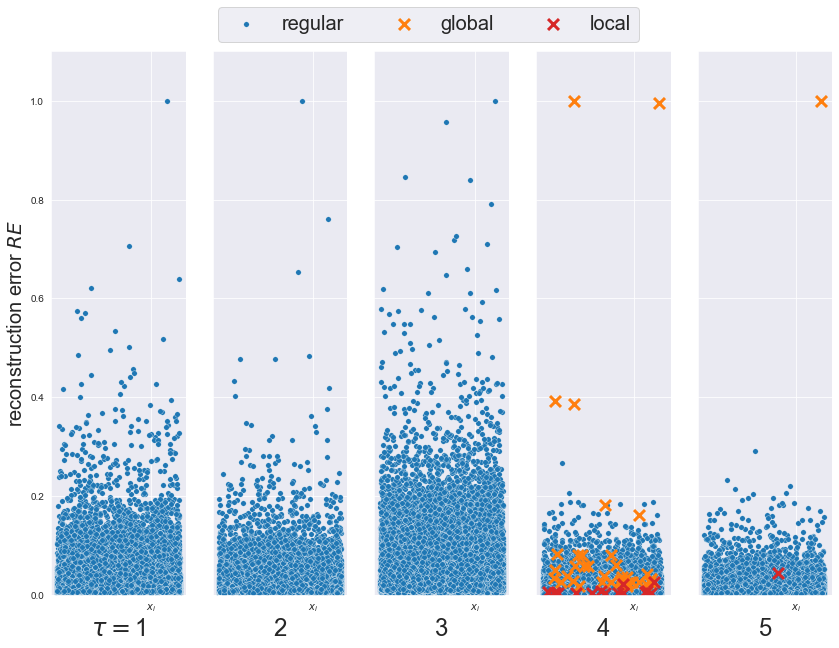

In [45]:
# normalize the reconstruction errors of each mode

# prepare empty arrays of the same shape and dtype
rec_error_all_scaled = np.asarray(rec_error_all)

# iterate over the cluster modes
for cluster_id in np.unique(cluster_ids).tolist():
  
    # determine journal entries of current mode
    mask = cluster_ids == cluster_id
    # normalize mode journal entries reconstruction error to the range [0,1]
    rec_error_all_scaled[mask] = (rec_error_all[mask] - rec_error_all[mask].min()) / (rec_error_all[mask].ptp())


# collect anomaly score, labels and cluster assignments
plot_data = pd.concat([pd.Series(rec_error_all_scaled, name='rec_error'), 
                       pd.Series(label, name='label'),                        
                       pd.Series(cluster_ids, name='cluster_id')],
                     axis=1)

num_clusters = len(np.unique(cluster_ids))
# init sub-plots based on the number of modes
fig, axes = plt.subplots(1, num_clusters, sharey=True, figsize=(14, 10))


# iterate over distinct modes
for mode in range(0, num_clusters):

    plot_data = plot_data.sample(frac=1.0)
    # collect features of current mode
    z_mode = plot_data[plot_data['cluster_id'] == mode]

    regular_data = z_mode[z_mode['label'] == 'regular']
    global_outliers = z_mode[z_mode['label'] == 'global']
    local_outliers = z_mode[z_mode['label'] == 'local']

    # create train scatter plot of regular samples
    axes[mode].scatter(regular_data.index, regular_data['rec_error'],
                       c='C0', marker='o', s=30, linewidth=0.3, label='regular', edgecolors='w')
    
    # create train scatter plot of global anomalies
    axes[mode].scatter(global_outliers.index, global_outliers['rec_error'],
                               c='C1', marker='x', s=120, linewidth=3, label='global', edgecolors='w')
    # create train scatter plot of local anomalies
    axes[mode].scatter(local_outliers.index, local_outliers['rec_error'],
                               c='C3', marker='x', s=120, linewidth=3, label='local', edgecolors='w')

    # set axis labels
    xlabel = '$\\tau={}$' + str(mode+1) if mode == 0 else str(mode+1)
    axes[mode].set_xlabel(xlabel, fontsize=24)

    # set axis limits
    axes[mode].set_ylim([0.0, 1.1])

    axes[mode].set_xticks([int(plot_data.shape[0]/2)])
    axes[mode].set_xticklabels(['$x_{i}$'])

# set axis labels
axes[0].set_ylabel('reconstruction error $RE$', fontsize=20)

# add legend to plot
handles, labels = axes[2].get_legend_handles_labels()
plt.legend(handles, labels, loc='center', fontsize=20, ncol=3, borderaxespad=0.,
           bbox_to_anchor=(-6.5, 1., 9., .1))

# set grid and tight plotting layout
plt.grid(True)
plt.savefig('AAE_Training_RE')

In [46]:
# find the cluster that contain the most anomaly points

label_train = label[:int(n*split_ratio)]
cluster_anomaly_number = [0]*5
# iterate over the cluster modes
for cluster_id in np.unique(cluster_ids).tolist():
  
    # determine journal entries of current mode
    mask = cluster_ids == cluster_id
    cluster_anomaly_number[cluster_id] = sum(label_train[mask] != 'regular')


In [47]:
non_regular_clusters = list(np.nonzero(cluster_anomaly_number)[0])
non_regular_clusters

[3, 4]

In [48]:
mask = np.isin(cluster_ids, non_regular_clusters)

In [49]:
from sklearn.metrics import roc_curve
y_true = (label != 'regular')[:int(n*split_ratio)]
tpr_target = 0.8
k = 55
# running a similar analysis ONLY in that cluster
rec_error_all_scaled_cluster = rec_error_all_scaled[mask]
mode_divergence_all_scaled_cluster = mode_divergence_all_scaled[mask]
y_true_cluster = y_true[mask]

# set alpha_list 
alpha_list = np.arange(11)/10

max_precision = -1e10
best_alpha = None
best_th = None
for alpha in alpha_list:
    # determine journal entry anomaly score
    anomaly_score_cluster = alpha * rec_error_all_scaled_cluster + (1.0 - alpha) * mode_divergence_all_scaled_cluster
    fpr, tpr, threshs = roc_curve(y_true_cluster, anomaly_score_cluster)

    th = threshs[np.argmax(tpr >= tpr_target) + 1]
    
    tp = sum(y_true_cluster[anomaly_score_cluster > th])
    fp = sum(anomaly_score_cluster > th) - tp
    fn = sum(y_true_cluster[anomaly_score_cluster <= th])
    tn = sum(anomaly_score_cluster <= th) - fn
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    
    top_k = (-anomaly_score_cluster).argsort()[:k]
    top_k_pos_rate = sum(y_true_cluster.values[top_k])/ k

    print('alpha: ', alpha,' precision: ', precision, 'top-k ', top_k_pos_rate, 'F1-score', f1, 'recall', recall)
    if precision > max_precision:
        max_precision = precision
        best_alpha = alpha
        best_th = th
print("best alpha: ", best_alpha)

alpha:  0.0  precision:  0.33587786259541985 top-k  0.6545454545454545 F1-score 0.4731182795698925 recall 0.8
alpha:  0.1  precision:  0.4731182795698925 top-k  0.6545454545454545 F1-score 0.5945945945945946 recall 0.8
alpha:  0.2  precision:  0.6027397260273972 top-k  0.6363636363636364 F1-score 0.6875 recall 0.8
alpha:  0.3  precision:  0.5789473684210527 top-k  0.6363636363636364 F1-score 0.6717557251908397 recall 0.8
alpha:  0.4  precision:  0.5789473684210527 top-k  0.6727272727272727 F1-score 0.6717557251908397 recall 0.8
alpha:  0.5  precision:  0.5365853658536586 top-k  0.6 F1-score 0.6423357664233577 recall 0.8
alpha:  0.6  precision:  0.3728813559322034 top-k  0.4727272727272727 F1-score 0.5086705202312138 recall 0.8
alpha:  0.7  precision:  0.20089285714285715 top-k  0.23636363636363636 F1-score 0.32258064516129037 recall 0.8181818181818182
alpha:  0.8  precision:  0.06676783004552352 top-k  0.14545454545454545 F1-score 0.12324929971988795 recall 0.8
alpha:  0.9  precision: 

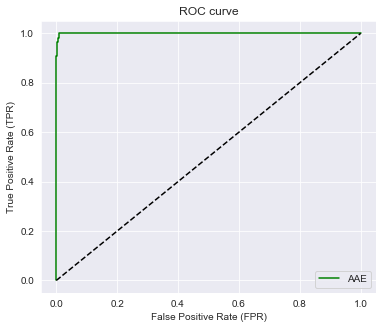

In [50]:
anomaly_score_cluster = best_alpha * rec_error_all_scaled_cluster + (1.0 - best_alpha) * mode_divergence_all_scaled_cluster
fpr, tpr, _ = roc_curve(y_true_cluster, anomaly_score_cluster)
fig, ax = plt.subplots(figsize = (6,5))
ax.plot(fpr, tpr, "g-", label = "AAE")
ax.plot([0,1],[0,1],"k--")
ax.set(xlabel = "False Positive Rate (FPR)",
       ylabel = "True Positive Rate (TPR)",
       title = "ROC curve")
ax.legend();
plt.savefig('AAE_Training_ROC')

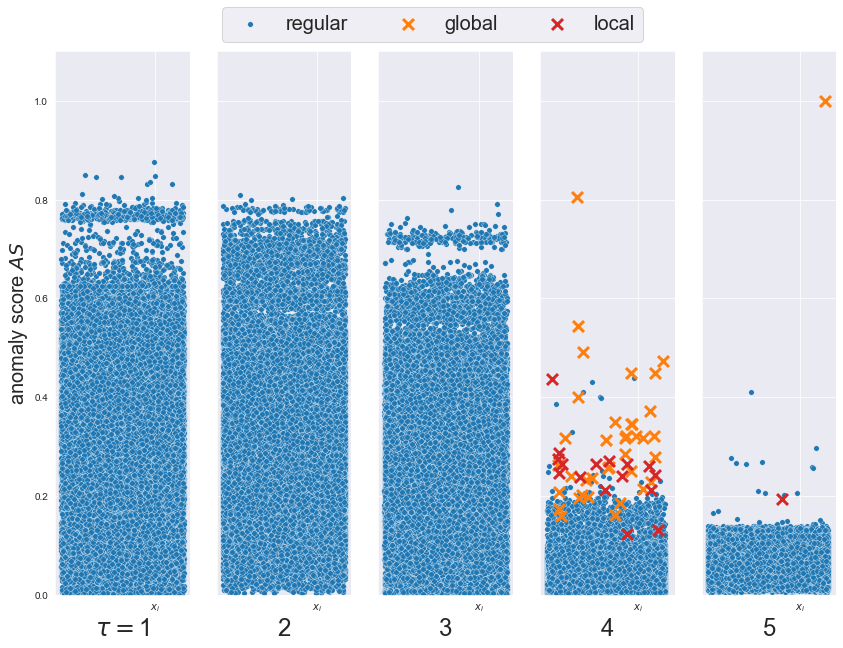

In [51]:
anomaly_score = best_alpha * rec_error_all + (1.0 - best_alpha) * mode_divergence_all_scaled

# collect anomaly score, labels and cluster assignments
plot_data = pd.concat([pd.Series(anomaly_score, name='anomaly_score'), 
                       pd.Series(label, name='label'),                        
                       pd.Series(cluster_ids, name='cluster_id')],
                     axis=1)

num_clusters = len(np.unique(cluster_ids))
# init sub-plots based on the number of modes
fig, axes = plt.subplots(1, num_clusters, sharey=True, figsize=(14, 10))

# iterate over distinct modes
for mode in range(0, num_clusters):

    plot_data = plot_data.sample(frac=1.0)
    # collect features of current mode
    z_mode = plot_data[plot_data['cluster_id'] == mode]

    regular_data = z_mode[z_mode['label'] == 'regular']
    global_outliers = z_mode[z_mode['label'] == 'global']
    local_outliers = z_mode[z_mode['label'] == 'local']

    # create train scatter plot of regular samples
    axes[mode].scatter(regular_data.index, regular_data['anomaly_score'],
                       c='C0', marker='o', s=30, linewidth=0.3, label='regular', edgecolors='w')
    
    # create train scatter plot of global anomalies
    axes[mode].scatter(global_outliers.index, global_outliers['anomaly_score'],
                               c='C1', marker='x', s=120, linewidth=3, label='global', edgecolors='w')
    # create train scatter plot of local anomalies
    axes[mode].scatter(local_outliers.index, local_outliers['anomaly_score'],
                               c='C3', marker='x', s=120, linewidth=3, label='local', edgecolors='w')

    # set axis labels
    xlabel = '$\\tau={}$' + str(mode+1) if mode == 0 else str(mode+1)
    axes[mode].set_xlabel(xlabel, fontsize=24)

    # set axis limits
    axes[mode].set_ylim([0.0, 1.1])

    axes[mode].set_xticks([int(plot_data.shape[0]/2)])
    axes[mode].set_xticklabels(['$x_{i}$'])

# set axis labels
axes[0].set_ylabel('anomaly score $AS$', fontsize=20)

# add legend to plot
handles, labels = axes[2].get_legend_handles_labels()
plt.legend(handles, labels, loc='center', fontsize=20, ncol=3, borderaxespad=0.,
           bbox_to_anchor=(-6.5, 1., 9., .1))

# set grid and tight plotting layout
plt.grid(True)
plt.savefig('AAE_Training_AS')

# Testing

In [52]:
z_enc_transactions_test

array([[0.87924784, 0.62817514],
       [0.8932955 , 0.6286471 ],
       [0.13262345, 0.62782633],
       ...,
       [0.11698018, 0.6138576 ],
       [0.48229432, 0.90602547],
       [0.2701003 , 0.18318732]], dtype=float32)

In [53]:
# testing
# Construct RE and MD

# determine distance to each mode
distances = np.apply_along_axis(func1d=compute_euclid_distance, 
                                axis=1, arr=z_enc_transactions_test, y=mu_gauss)

# determine mode divergence
mode_divergence = np.min(distances, axis=1)

# determine min-mode id
cluster_ids = np.argmin(distances, axis=1) 

# normalize the mode divergences of each mode
# prepare empty arrays of the same shape and dtype
mode_divergence_all_scaled = np.asarray(mode_divergence)

# iterate over the cluster modes
for cluster_id in np.unique(cluster_ids).tolist():
  
    # determine journal entries of current mode
    mask = cluster_ids == cluster_id

    # normalize mode journal entries mode divergence to the range [0,1]
    mode_divergence_all_scaled[mask] = (mode_divergence[mask] - mode_divergence[mask].min()) / (mode_divergence[mask].ptp())   



In [54]:
# normalize the reconstruction errors of each mode

# prepare empty arrays of the same shape and dtype
rec_error_all_scaled = np.asarray(rec_error_test)

# iterate over the cluster modes
for cluster_id in np.unique(cluster_ids).tolist():
  
    # determine journal entries of current mode
    mask = cluster_ids == cluster_id
    # normalize mode journal entries reconstruction error to the range [0,1]
    rec_error_all_scaled[mask] = (rec_error_test[mask] - rec_error_test[mask].min()) / (rec_error_test[mask].ptp())



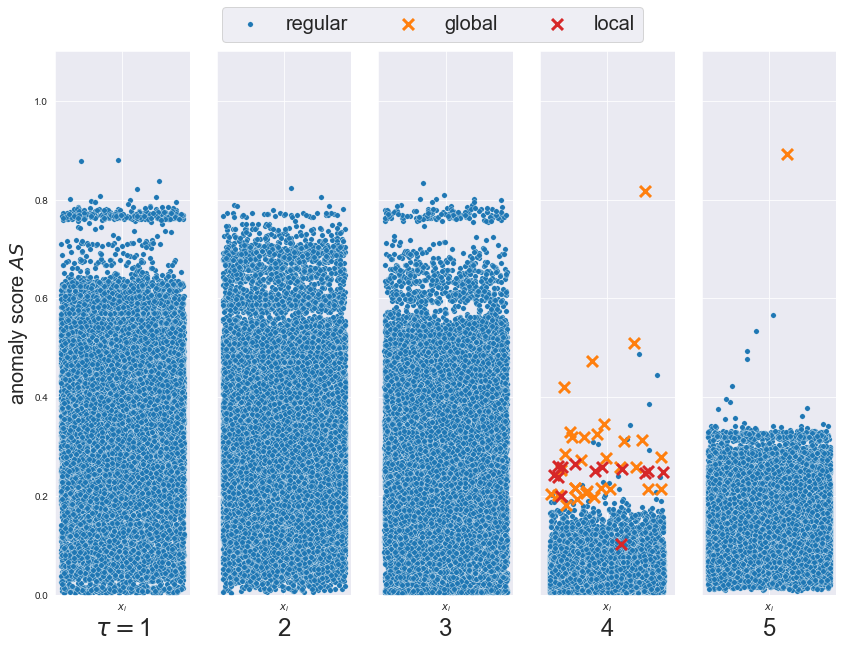

In [55]:
anomaly_score = best_alpha * rec_error_all_scaled + (1.0 - best_alpha) * mode_divergence_all_scaled
# collect anomaly score, labels and cluster assignments
plot_data = pd.concat([pd.Series(anomaly_score, name='anomaly_score'), 
                       pd.Series(list(label[int(n*split_ratio):]), name='label'),                        
                       pd.Series(cluster_ids, name='cluster_id')],
                     axis=1)

num_clusters = len(np.unique(cluster_ids))
# init sub-plots based on the number of modes
fig, axes = plt.subplots(1, num_clusters, sharey=True, figsize=(14, 10))

# iterate over distinct modes
for mode in range(0, num_clusters):

    plot_data = plot_data.sample(frac=1.0)
    # collect features of current mode
    z_mode = plot_data[plot_data['cluster_id'] == mode]

    regular_data = z_mode[z_mode['label'] == 'regular']
    global_outliers = z_mode[z_mode['label'] == 'global']
    local_outliers = z_mode[z_mode['label'] == 'local']

    # create train scatter plot of regular samples
    axes[mode].scatter(regular_data.index, regular_data['anomaly_score'],
                       c='C0', marker='o', s=30, linewidth=0.3, label='regular', edgecolors='w')
    
    # create train scatter plot of global anomalies
    axes[mode].scatter(global_outliers.index, global_outliers['anomaly_score'],
                               c='C1', marker='x', s=120, linewidth=3, label='global', edgecolors='w')
    # create train scatter plot of local anomalies
    axes[mode].scatter(local_outliers.index, local_outliers['anomaly_score'],
                               c='C3', marker='x', s=120, linewidth=3, label='local', edgecolors='w')

    # set axis labels
    xlabel = '$\\tau={}$' + str(mode+1) if mode == 0 else str(mode+1)
    axes[mode].set_xlabel(xlabel, fontsize=24)

    # set axis limits
    axes[mode].set_ylim([0.0, 1.1])

    axes[mode].set_xticks([int(plot_data.shape[0]/2)])
    axes[mode].set_xticklabels(['$x_{i}$'])

# set axis labels
axes[0].set_ylabel('anomaly score $AS$', fontsize=20)

# add legend to plot
handles, labels = axes[2].get_legend_handles_labels()
plt.legend(handles, labels, loc='center', fontsize=20, ncol=3, borderaxespad=0.,
           bbox_to_anchor=(-6.5, 1., 9., .1))

# set grid and tight plotting layout
plt.grid(True)
plt.savefig('AAE_Testing_AS')

In [56]:
y_true = (label!='regular')[int(n*split_ratio):]
print('best alpha: ', best_alpha, 'best threshold: ', best_th)

best alpha:  0.2 best threshold:  0.20944804430270095


In [57]:
non_regular_clusters

[3, 4]

In [58]:
k = 45

mask = np.isin(cluster_ids, non_regular_clusters)
rec_error_all_scaled_cluster = rec_error_all_scaled[mask]
mode_divergence_all_scaled_cluster = mode_divergence_all_scaled[mask]

In [59]:
y_true_cluster = y_true[mask]
anomaly_score_cluster = best_alpha * rec_error_all_scaled_cluster + (1.0 - best_alpha) * mode_divergence_all_scaled_cluster


In [60]:
fpr, tpr, threshs = roc_curve(y_true_cluster, anomaly_score_cluster)

tp = sum(y_true_cluster[anomaly_score_cluster > best_th])
fp = sum(anomaly_score_cluster > best_th) - tp
fn = sum(y_true_cluster[anomaly_score_cluster <= best_th])
tn = sum(anomaly_score_cluster <= best_th) - fn

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)

top_k = (-anomaly_score_cluster).argsort()[:k]
top_k_pos_rate = sum(y_true_cluster.values[top_k])/ k
print('precision: ', precision, 'top-k ', top_k_pos_rate, 'F1-score', f1, 'recall: ', recall)

precision:  0.008247882300490415 top-k  0.13333333333333333 F1-score 0.016331935555065107 recall:  0.8222222222222222
